# Experiment 2.2
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Conducting experiments for checking the viewpoint invaraince of the activity features extracted using C3D pretrained model. <br>
Features used: Features just after the conv layers is used. <br>
Video used: cup moving <br>
Experiment detail : Videos of same action captured from different viewpoints. Maximum syncd + compressed + half cut  <br>


In [1]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [2]:
## Imports
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
import random
import numpy as np
from PIL import Image
from os import listdir
from scipy.ndimage import imread

# Custom scripts
import lscript as lsp
import modelling as md
import dataset as dset
from read_activations import *

In [3]:
height=112 
width=112 
channel=3
nb_class=3
cluster_length=8
strides=9
total_frames_in_seq=18
time_step=18
num_clusters= int( (total_frames_in_seq-cluster_length) / strides) + 1
feature_size=8192
#8192   #16384  #487


#### Loading Leeds Dataset

In [4]:
imagefolderpath= ('/nobackup/leopauly/View_invariance_Dataset/cupmove1compresscut_view0/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
vids=dset.viewpoint_data(time_step,height,width,channel,imagefolderpath,gray=False,normalisation=True)

True


(18, 112, 112, 3)


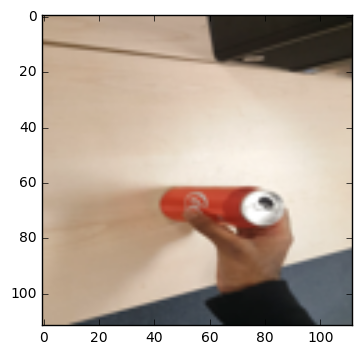

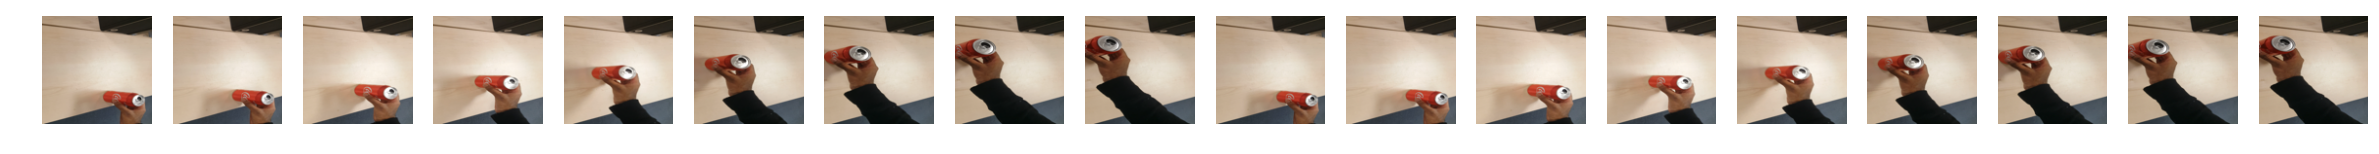

In [5]:
print (vids.shape)
y_=np.empty([1])
lsp.view_image(vids[3],image_details=False)
lsp.single_video_inline(vids,y_,time_step)

label:[  1.25986740e-321]
Video_seq shape: (18, 112, 112, 3) Label shape (1,)


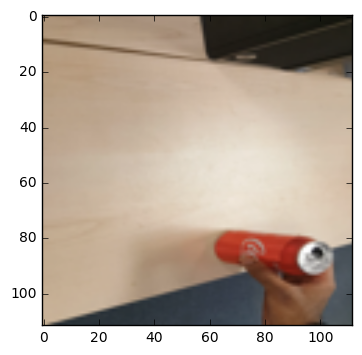

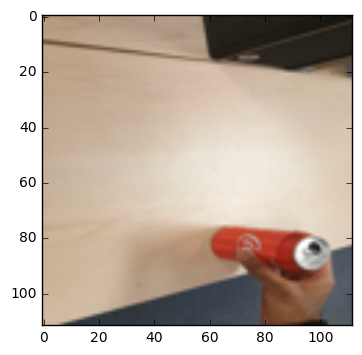

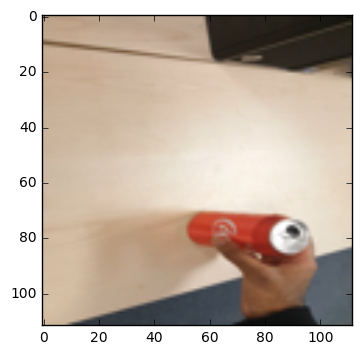

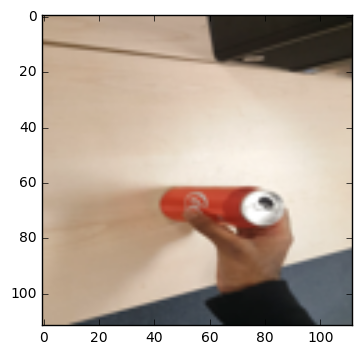

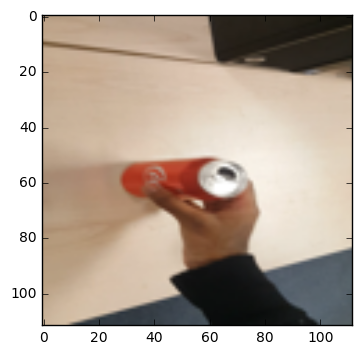

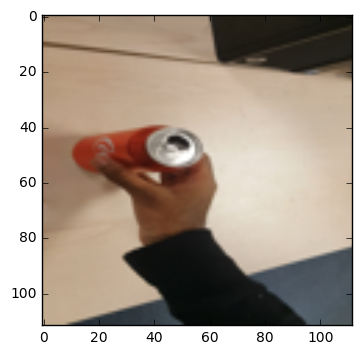

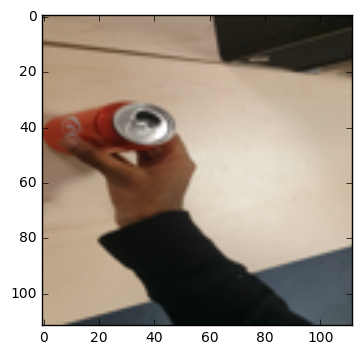

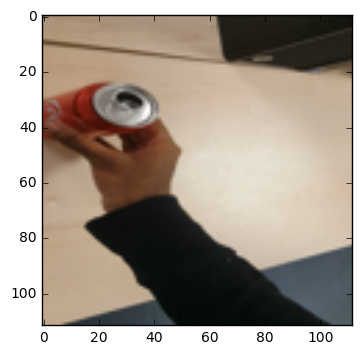

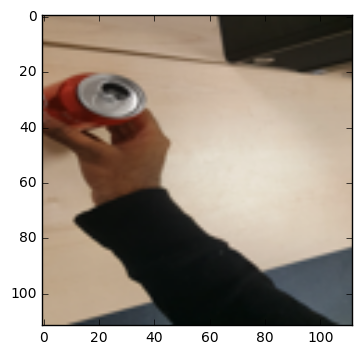

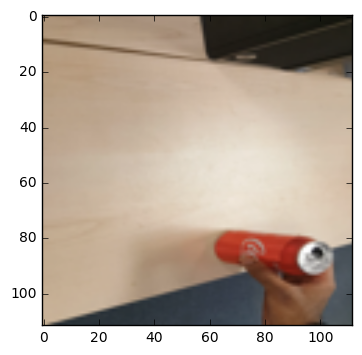

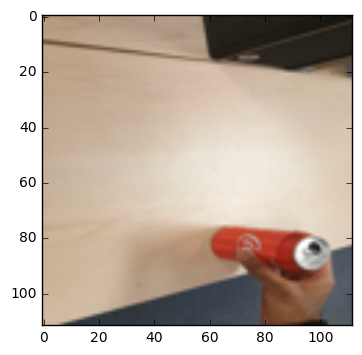

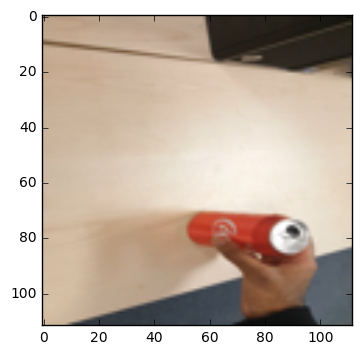

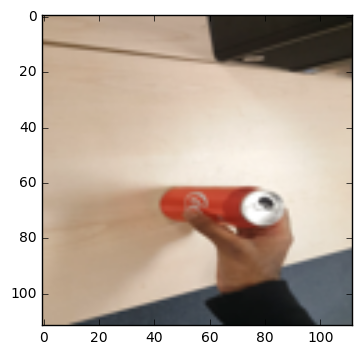

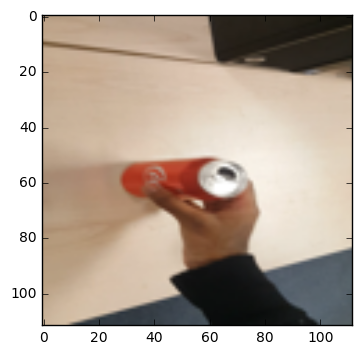

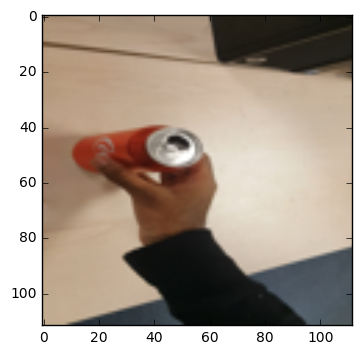

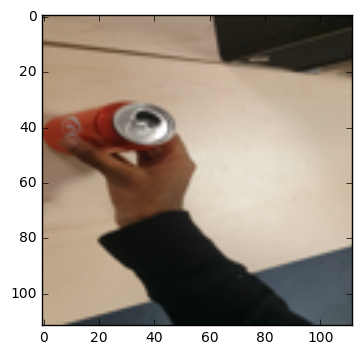

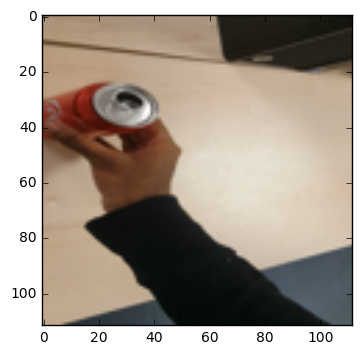

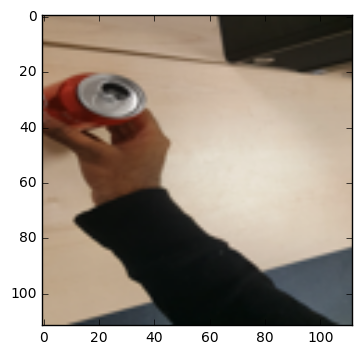

In [6]:
lsp.single_video_seq(vids,y_,time_step)

#### Loading model

In [7]:
model=md.custom_modelC3D_theano(cluster_length)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution3D)            (None, 64, 8, 112, 11 0           convolution3d_input_1[0][0]      
____________________________________________________________________________________________________
pool1 (MaxPooling3D)             (None, 64, 8, 56, 56) 0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution3D)            (None, 128, 8, 56, 56 0           pool1[0][0]                      
____________________________________________________________________________________________________
pool2 (MaxPooling3D)             (None, 128, 4, 28, 28 0           conv2[0][0]                      
___________________________________________________________________________________________

#### Extracting features

In [8]:
imagefolderpath= ('/nobackup/leopauly/View_invariance_Dataset/cupmove1compresscut_view0/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
vids=dset.viewpoint_data(time_step,height,width,channel,imagefolderpath,gray=False,normalisation=True)

True


In [9]:
## Splitting into clusters the video of source demonstration
x_demo = vids
x_demo_original=x_demo
x_demo =x_demo.reshape(1,x_demo.shape[0],height,width,channel)
clusters_demo=dset.clusters_with_strides(x_demo,num_clusters,cluster_length,height,width,channel,strides)

## Extraction of features
print('shape of clustered demo data:',clusters_demo.shape)
features_demo=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters_demo[i].reshape(1,channel,cluster_length,height,width)
    
    t_f=np.array(get_activations(model,t,print_shape_only=True,layer_name='flatten'))
    t_f=t_f.reshape(t_f.shape[0],t_f.shape[2])
    #t_f=model.predict(t)
    
    features_demo[i]= t_f   
    #print(features)
print('shape of features from robot actions: ',features_demo.shape)

(2, 8, 112, 112, 3)
shape of clustered demo data: (2, 8, 112, 112, 3)
shape of features from robot actions:  (2, 8192)


In [10]:
imagefolderpath= ('/nobackup/leopauly/View_invariance_Dataset/cupmove1compresscut_view1/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath))
vids=dset.viewpoint_data(time_step,height,width,channel,imagefolderpath,gray=False,normalisation=True)

True


In [11]:
## Splitting into & displaying clusters of target actions
x_robo=vids
x_robo_original=x_robo
x_robo =x_robo.reshape(1,x_robo.shape[0],height,width,channel)
clusters_robo=dset.clusters_with_strides(x_robo,num_clusters,cluster_length,height,width,channel,strides)

## Extracting features
print('shape of clustered robot data:',clusters_robo.shape)
features_robo=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters_robo[i].reshape(1,channel,cluster_length,height,width)
    
    t_f=np.array(get_activations(model,t,print_shape_only=True,layer_name='flatten'))
    t_f=t_f.reshape(t_f.shape[0],t_f.shape[2])
    #t_f=model.predict(t)
    
    features_robo[i]= t_f   
    #print(features)
print('shape of features from robot actions: ', features_robo.shape)

(2, 8, 112, 112, 3)
shape of clustered robot data: (2, 8, 112, 112, 3)
shape of features from robot actions:  (2, 8192)


#### Extracting reward function

In [12]:
distance=np.ones([num_clusters,feature_size])
reward=np.ones([num_clusters,1])
for i in range(num_clusters):
    distance[i] = features_demo[i]-features_robo[i]
    reward[i]=-(np.linalg.norm(distance[i]))
print(reward)
print(distance)

[[-9.81707497]
 [-8.27599877]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


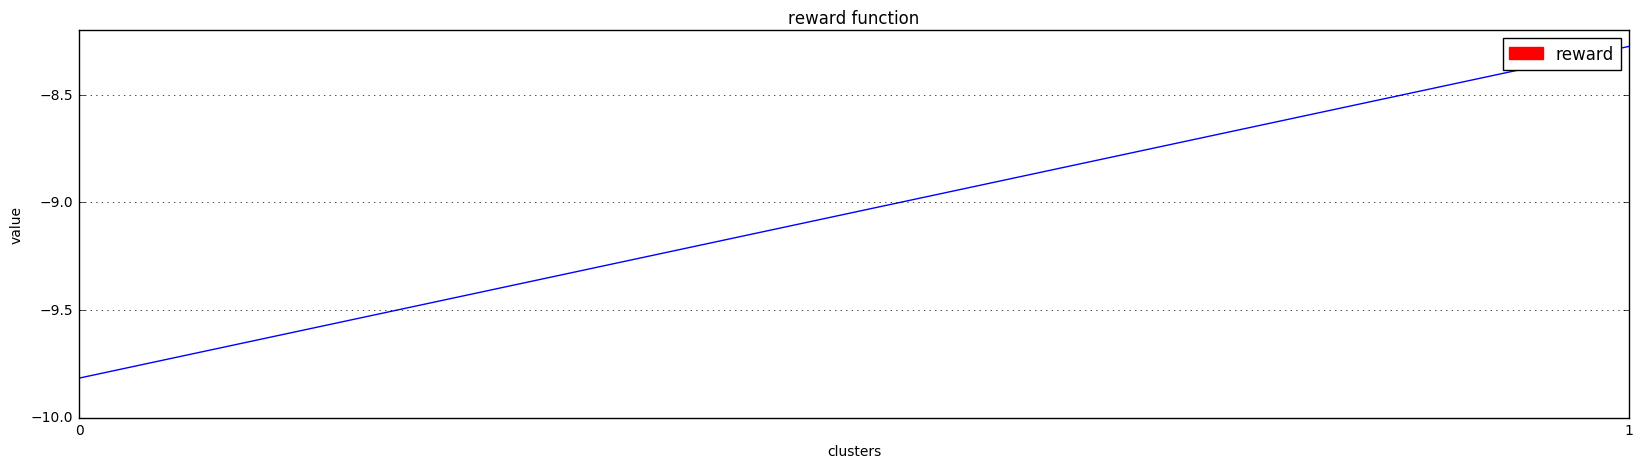

In [13]:
y_vlaues=list((range(num_clusters)))
lsp.plot_values_with_legends(y_vlaues,reward,'reward','clusters','value','reward function',color='red',ylim=True)

#### Displaying cluster

cluster no:  0


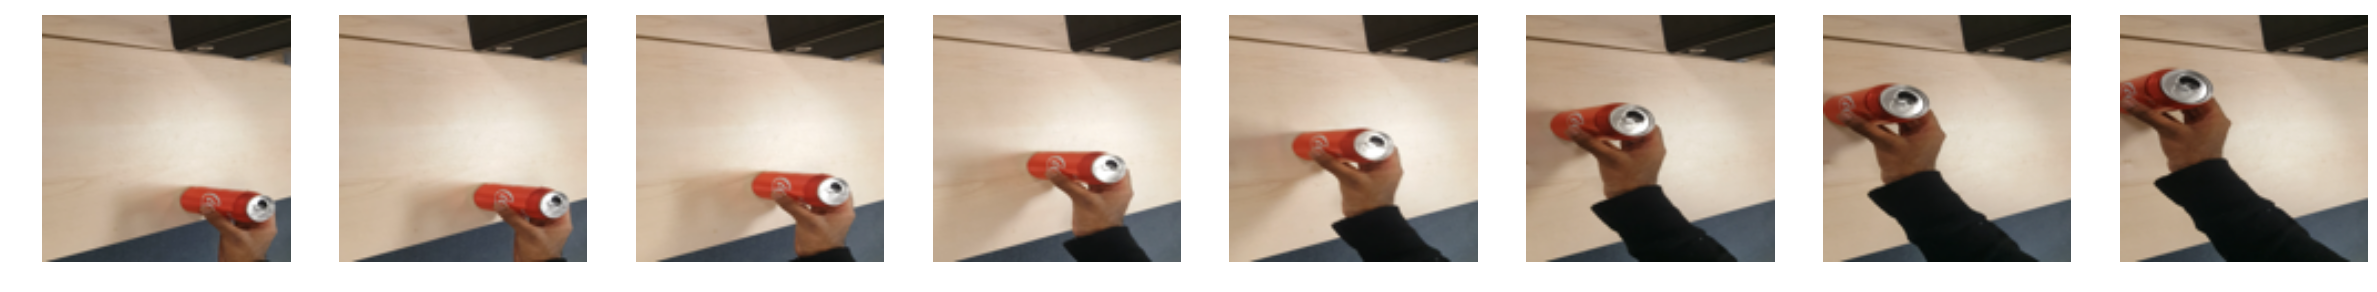

cluster no:  1


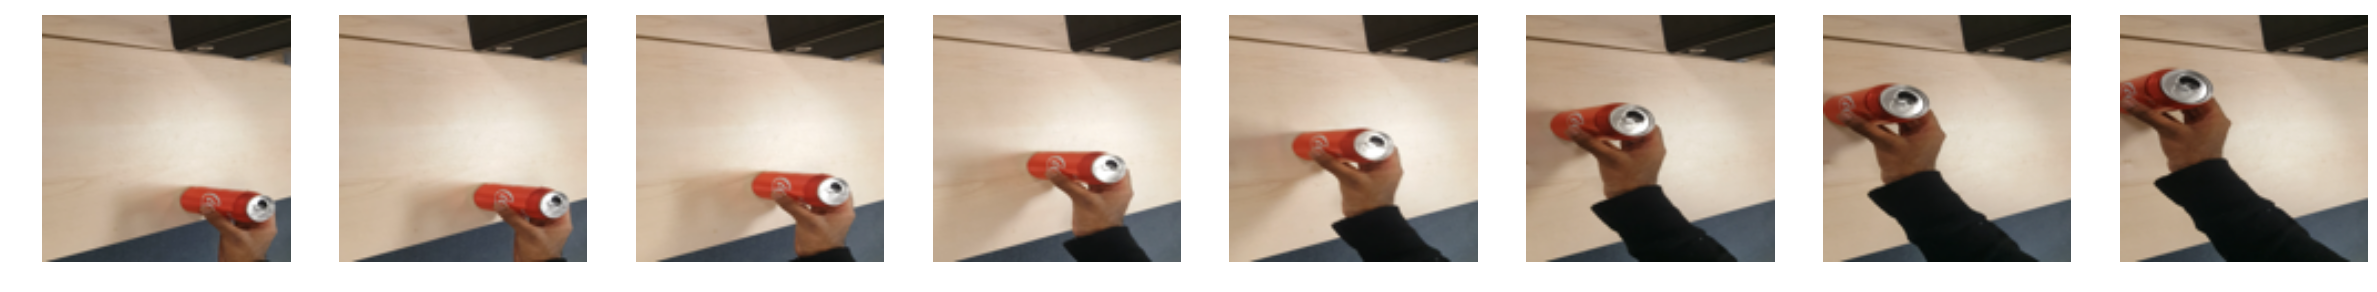

In [14]:
## Clusters from demos
for i in range(num_clusters):
    cluster_id=i
    y_d=np.repeat(y_,num_clusters)
    print('cluster no: ',i)
    display=clusters_demo.reshape(clusters_demo.shape[0],clusters_demo.shape[1],clusters_demo.shape[2],clusters_demo.shape[3],clusters_demo.shape[4])
    lsp.view_video_inline(display,y_d,cluster_length,cluster_id)

cluster no:  0


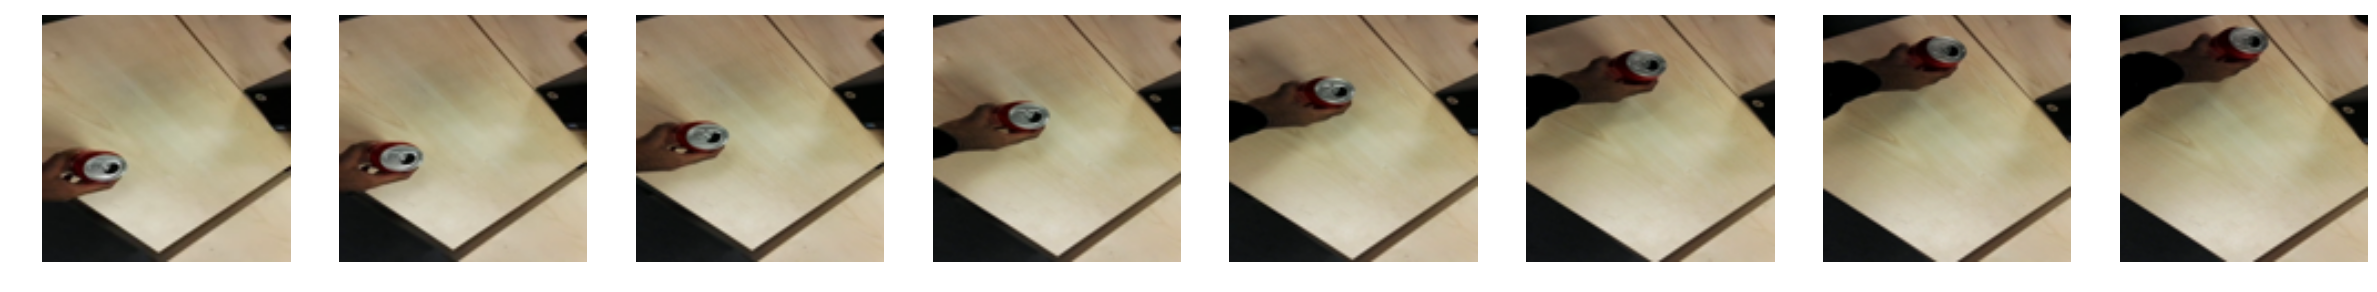

cluster no:  1


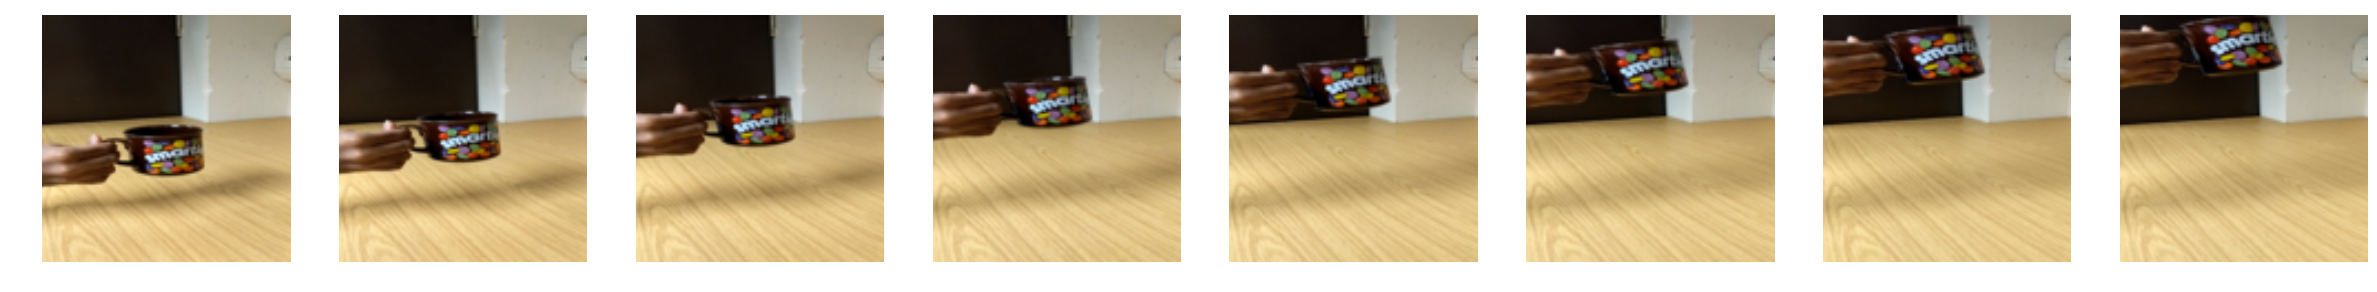

In [15]:
## Clusters from robot action
y_r=np.repeat(y_,num_clusters)
for i in range(num_clusters):
    cluster_id=i 
    print('cluster no: ',i)
    display=clusters_robo.reshape(clusters_robo.shape[0],clusters_robo.shape[1],clusters_robo.shape[2],clusters_robo.shape[3],clusters_robo.shape[4])
    lsp.view_video_inline(display,y_r,cluster_length,cluster_id)

#### Displaying full video sequences

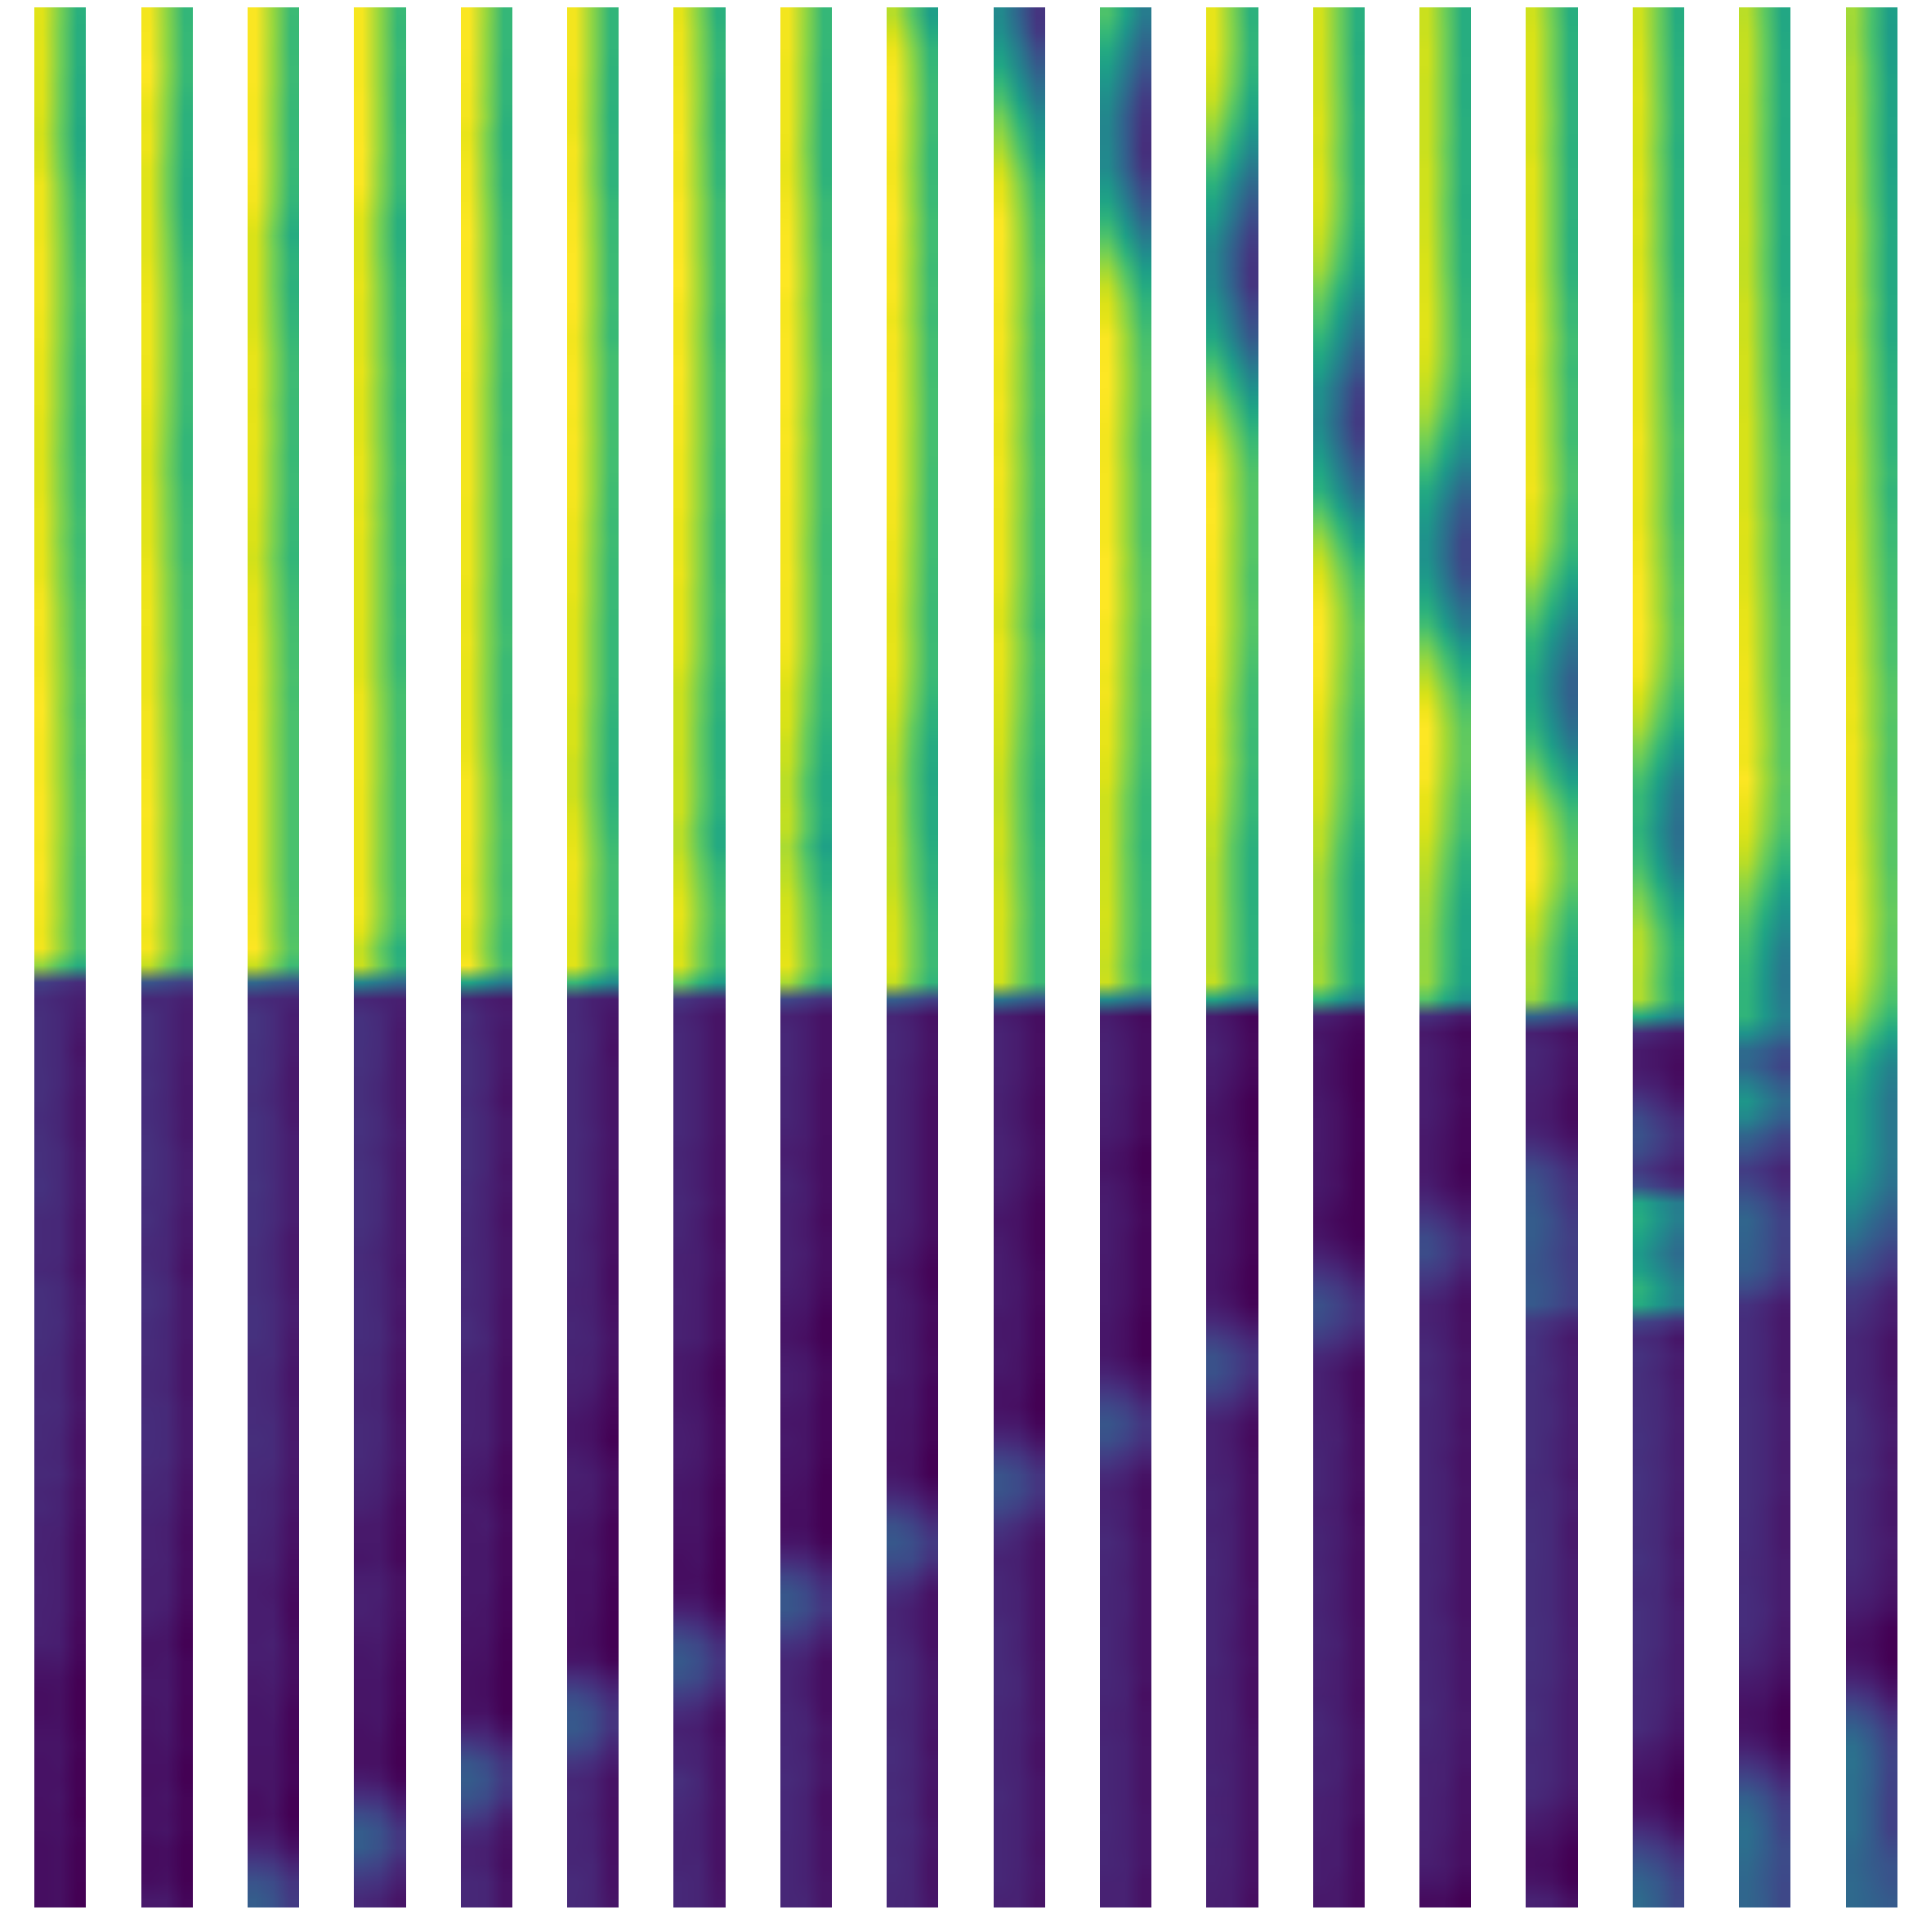

label:0.0
Video_seq shape: (18, 112, 112, 3) Label shape (1,)


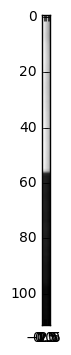

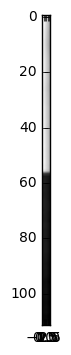

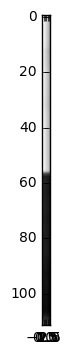

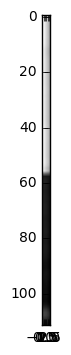

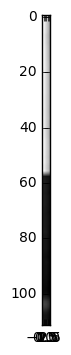

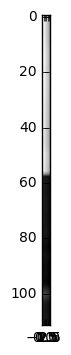

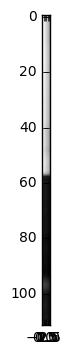

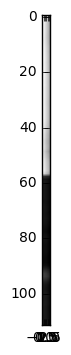

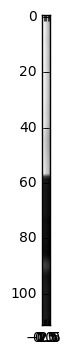

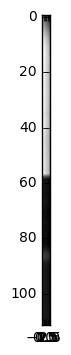

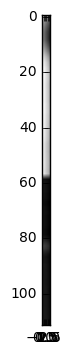

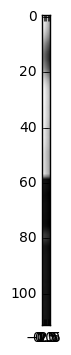

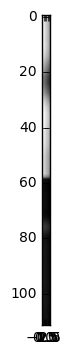

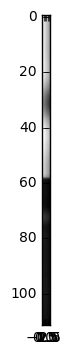

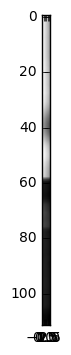

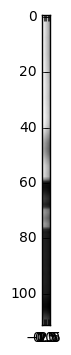

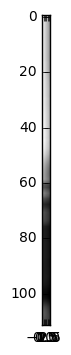

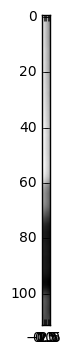

In [16]:
## Demo / Source video
y_=np.zeros([1])
lsp.view_video_inline(x_demo_original,y_,time_step,0)
lsp.view_video_seq(x_demo_original,y_,time_step,0)

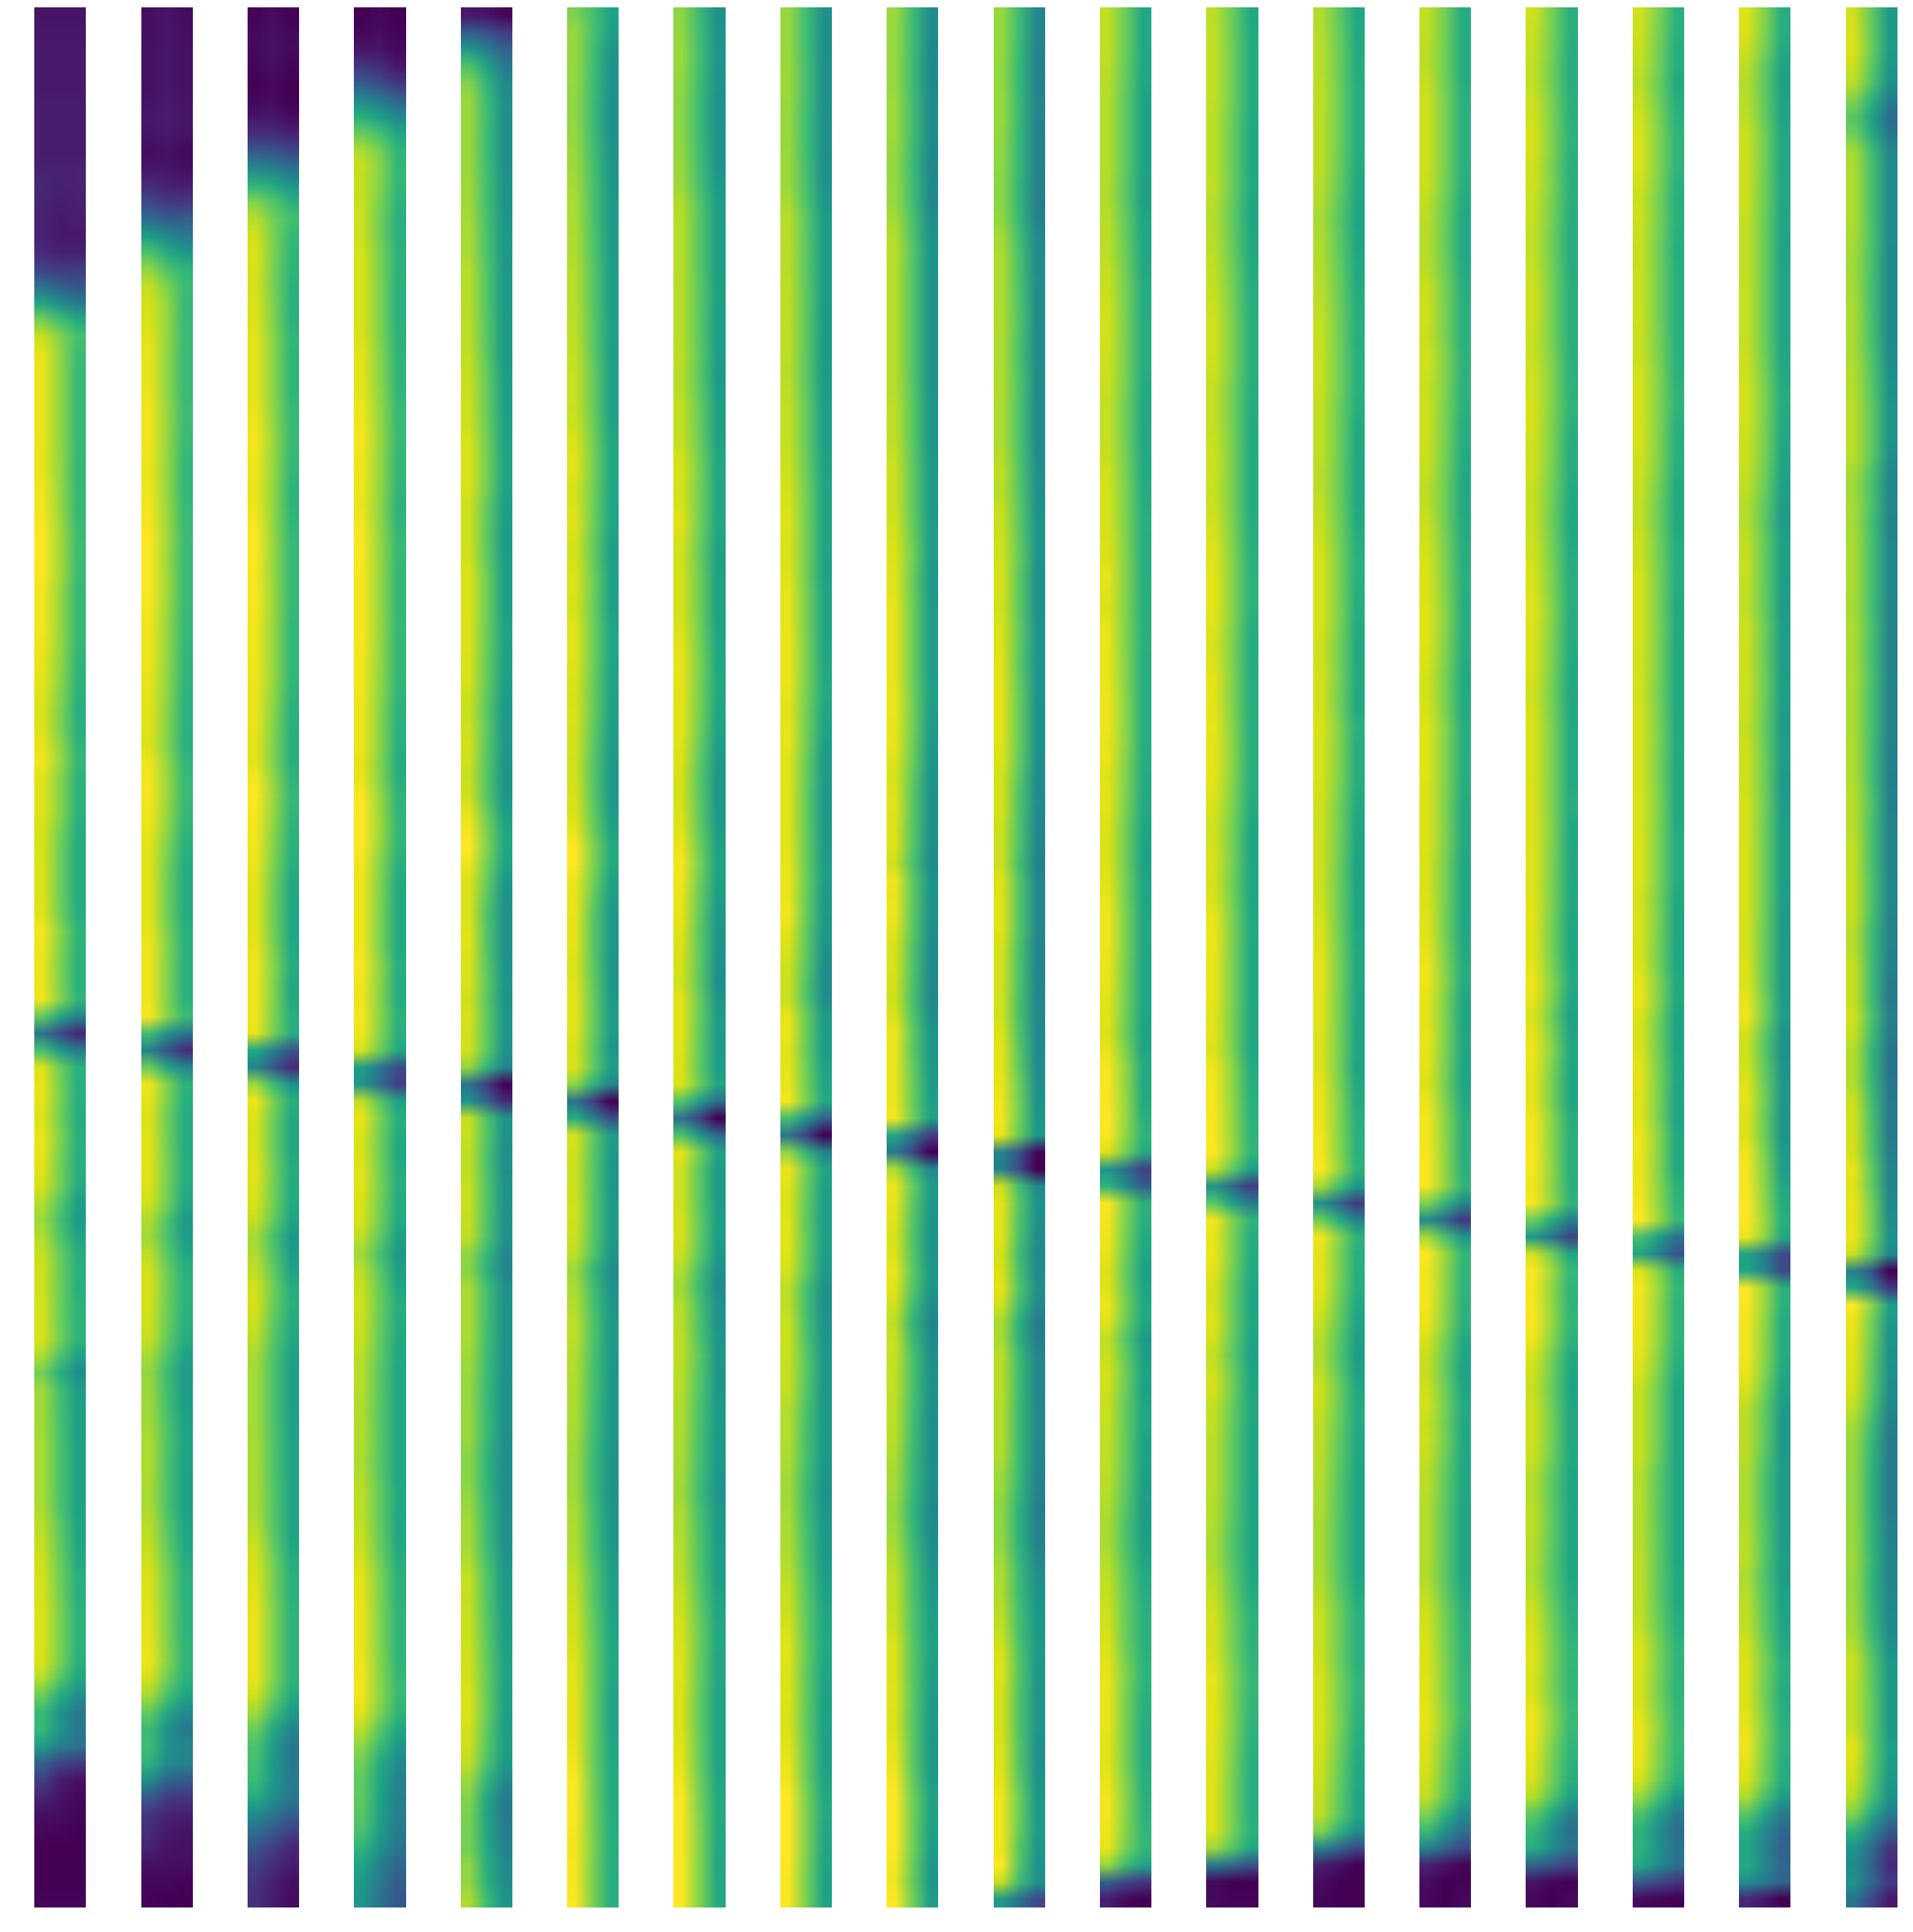

label:0.0
Video_seq shape: (18, 112, 112, 3) Label shape (1,)


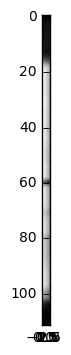

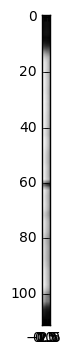

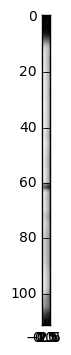

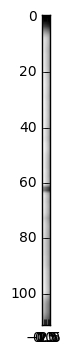

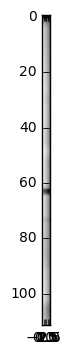

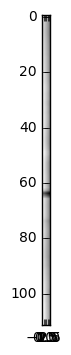

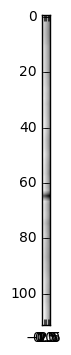

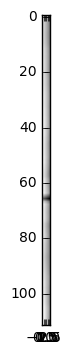

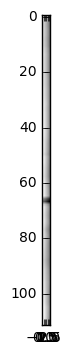

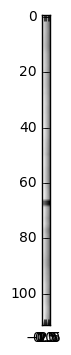

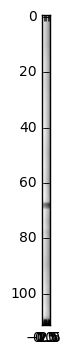

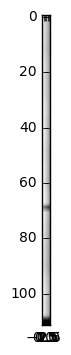

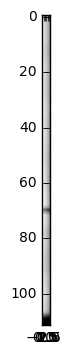

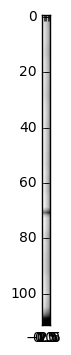

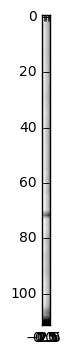

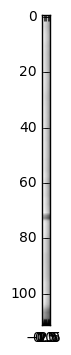

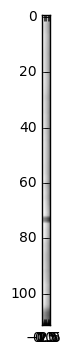

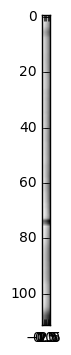

In [17]:
### Target / robot video
y_=np.zeros([1])
lsp.view_video_inline(x_robo_original,y_,time_step,0)
lsp.view_video_seq(x_robo_original,y_,time_step,0)